In [2]:
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from os import path
import matplotlib.pyplot as plt

In [3]:
def read_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

books = [
    "tinyshakespear", "book-war-and-peace", "Frankenstein",
    "moby_dick", "pride_and_prejudice", "taylor_swift", "wonderland"
]

all_texts = []
for book in books:
    filepath = path.join("./data", book + ".txt")
    all_texts.append(read_data(filepath))

data = "".join(all_texts)

print(f"Total length: {len(data)} characters.")

Total length: 8185009 characters.


In [4]:
enc = tiktoken.get_encoding("r50k_base")

In [5]:
vocab_size = enc.n_vocab
print(enc.decode([i for i in range(vocab_size) ]))
print(vocab_size)

!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~���������������������������������������������������������������������������������������������� 	
 ���������������������������������� t aheinreon theer sat w oen citisanores bed fing pou analar to m of in d h andicasle thionomllent n lst reve eroly be g Tct Sidot Iutet A is onimamowayadse that Cig forac yverur uld st M's he itationithirce youil B whol P with 1terch as we (ndill Dif 2agerske " Hem con W Rher was rod Fulate atrippore The seus pro haum are deainand orighestistabrom Nth com Gunop00 L notess ex vres Eewityant byelosortocqu from have suiveould sh thisntrapeightartment alustend--all Oack ch leiesredard�out J abearivallyourostghpt plast canakomeudThe his do go hasge't Urou sa j but wor allect kame willok whe theyide01ffichplther tr.. intieureage neialapineice me outansoneongions who K up their ad 3 usatedous moreueog Stindike soimeper."berizact one said -are yo

In [6]:
encoded_data = np.array(list(enc.encode(data)))

split_index = int(len(encoded_data) * 0.9)
train_data = encoded_data[:split_index]
test_data = encoded_data[split_index:]

print(f"Total data length: {len(encoded_data)}")
print(f"Split index: {split_index}")
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Sum of train and test lengths: {len(train_data) + len(test_data)}")

Total data length: 2191900
Split index: 1972710
Train data length: 1972710
Test data length: 219190
Sum of train and test lengths: 2191900


In [7]:
d_model = 64
vocab_size = enc.n_vocab
batch_size = 16
seq_len = 16
lr = 0.001
epochs = 40_000
eval_iters = 20
device = 'mps'

In [8]:
def get_batch(split):
    data_ = train_data if split == 'train' else test_data
    ix = torch.randint(len(data_) - seq_len, (batch_size, ))
    x = torch.stack([torch.from_numpy((data_[i:i+seq_len]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data_[i+1:i+1+seq_len]).astype(np.int64)) for i in ix])
    return x, y

In [9]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        
        self.W_E = nn.Embedding(vocab_size, d_model)
        self.unembed = nn.Linear(d_model, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        token_vectors = self.W_E(x)
        logits = self.unembed(token_vectors)
        return logits


In [10]:
model = TokenEmbedding(vocab_size, d_model)
optim = optim.AdamW(model.parameters(), lr)
model.to(device)

TokenEmbedding(
  (W_E): Embedding(50257, 64)
  (unembed): Linear(in_features=64, out_features=50257, bias=True)
)

In [11]:
for epoch in range(epochs):
    model.train()
    
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # Forward pass
    logits = model(xb)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T))

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 1000 == 0:
        print(f"====== Loss {epoch}: {loss.item()}")

====== Loss 0: 10.942161560058594
====== Loss 1000: 7.533095836639404
====== Loss 2000: 6.59075403213501
====== Loss 3000: 6.3311614990234375
====== Loss 4000: 6.548674583435059
====== Loss 5000: 6.336117744445801
====== Loss 6000: 6.644214630126953
====== Loss 7000: 5.74022912979126
====== Loss 8000: 5.997843265533447
====== Loss 9000: 5.8306965827941895
====== Loss 10000: 5.91405725479126
====== Loss 11000: 5.783397674560547
====== Loss 12000: 6.0069684982299805
====== Loss 13000: 5.743250370025635
====== Loss 14000: 5.608973026275635
====== Loss 15000: 5.636179447174072
====== Loss 16000: 5.523785591125488
====== Loss 17000: 5.5630106925964355
====== Loss 18000: 5.59730863571167
====== Loss 19000: 5.786192417144775
====== Loss 20000: 5.973649024963379
====== Loss 21000: 5.666036128997803
====== Loss 22000: 5.867327690124512
====== Loss 23000: 6.360820770263672
====== Loss 24000: 5.796999931335449
====== Loss 25000: 6.011791706085205
====== Loss 26000: 5.59764289855957
====== Loss 27

In [12]:
from torch.nn.functional import cosine_similarity
embedding_weights = model.W_E.weight

def find_closest_words(word, top_n=50):
    word_id = enc.encode(word)
    word_vector = embedding_weights[word_id]
    
    similarities = cosine_similarity(word_vector.unsqueeze(0), embedding_weights)
    
    top_values, top_indices = similarities.topk(top_n + 1)
    
    print(f"\nWords most similar to '{word}':")
    for i in range(1, top_n + 1): # Start at 1 to skip the word itself
        similar_word_id = top_indices[0][i].item()
        print(similar_word_id)
        similar_word = enc.decode([similar_word_id])
        similarity_score = top_values[0][i].item()
        print(f"   - {similar_word}: {similarity_score:.4f}")

find_closest_words("cat", top_n=5)
find_closest_words("love", top_n=5)


Words most similar to 'cat':
34
   - C: 0.0396
55
   - X: 0.0396
20
   - 5: 0.0381
63
   - `: 0.0373
29
   - >: 0.0371

Words most similar to 'love':
34
   - C: 0.0396
55
   - X: 0.0396
9
   - *: 0.0392
2
   - #: 0.0377
29
   - >: 0.0371


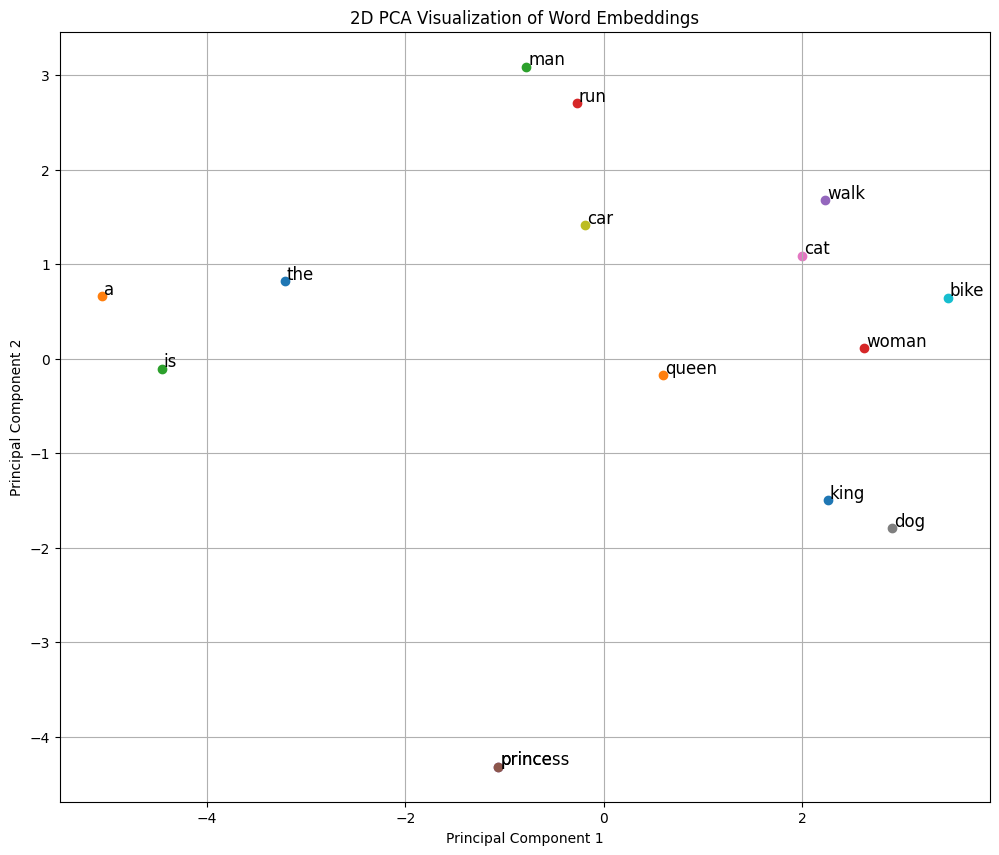

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings = model.W_E.weight.detach().cpu().numpy()
vocab_size, d_model = embeddings.shape

all_tokens = [enc.decode([i]) for i in range(vocab_size)]

words_to_track = ["king", "queen", "man", "woman", "prince", "princess", 
                  "cat", "dog", "car", "bike", "the", "a", "is", "run", "walk"]

indices_to_track = [enc.encode(word)[0] for word in words_to_track]

embeddings_subset = embeddings[indices_to_track]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_subset)

plt.figure(figsize=(12, 10))

for i, word in enumerate(words_to_track):
    x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.title("2D PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [16]:
vs = torch.tensor([i for i in range(vocab_size)])
vs.to(device)
model.eval()
model.to('cpu')
logits_ = model(vs)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
        66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
        77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
        88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
        99.5]),
 [Text(0, 0.5, 'th'),
  Text(0, 1.5, ' com'),
  Text(0, 2.5, ' G'),
  Text(0, 3.5, 'un'),
  Text(0, 4.5, 'op'),
  Text(0, 5.5, '00'),
  Text(0, 6.5, ' L'),
  Text(0, 7.5, ' not'),
  Text(0, 8.5, 'ess'),
  Text(0, 9.5, ' ex'),
  Text(0, 10.5, ' v'),
  Text(0, 11.5, 'res'),
  Text(0, 12.5, ' E'),
  Text(0, 13.5, 'ew'),

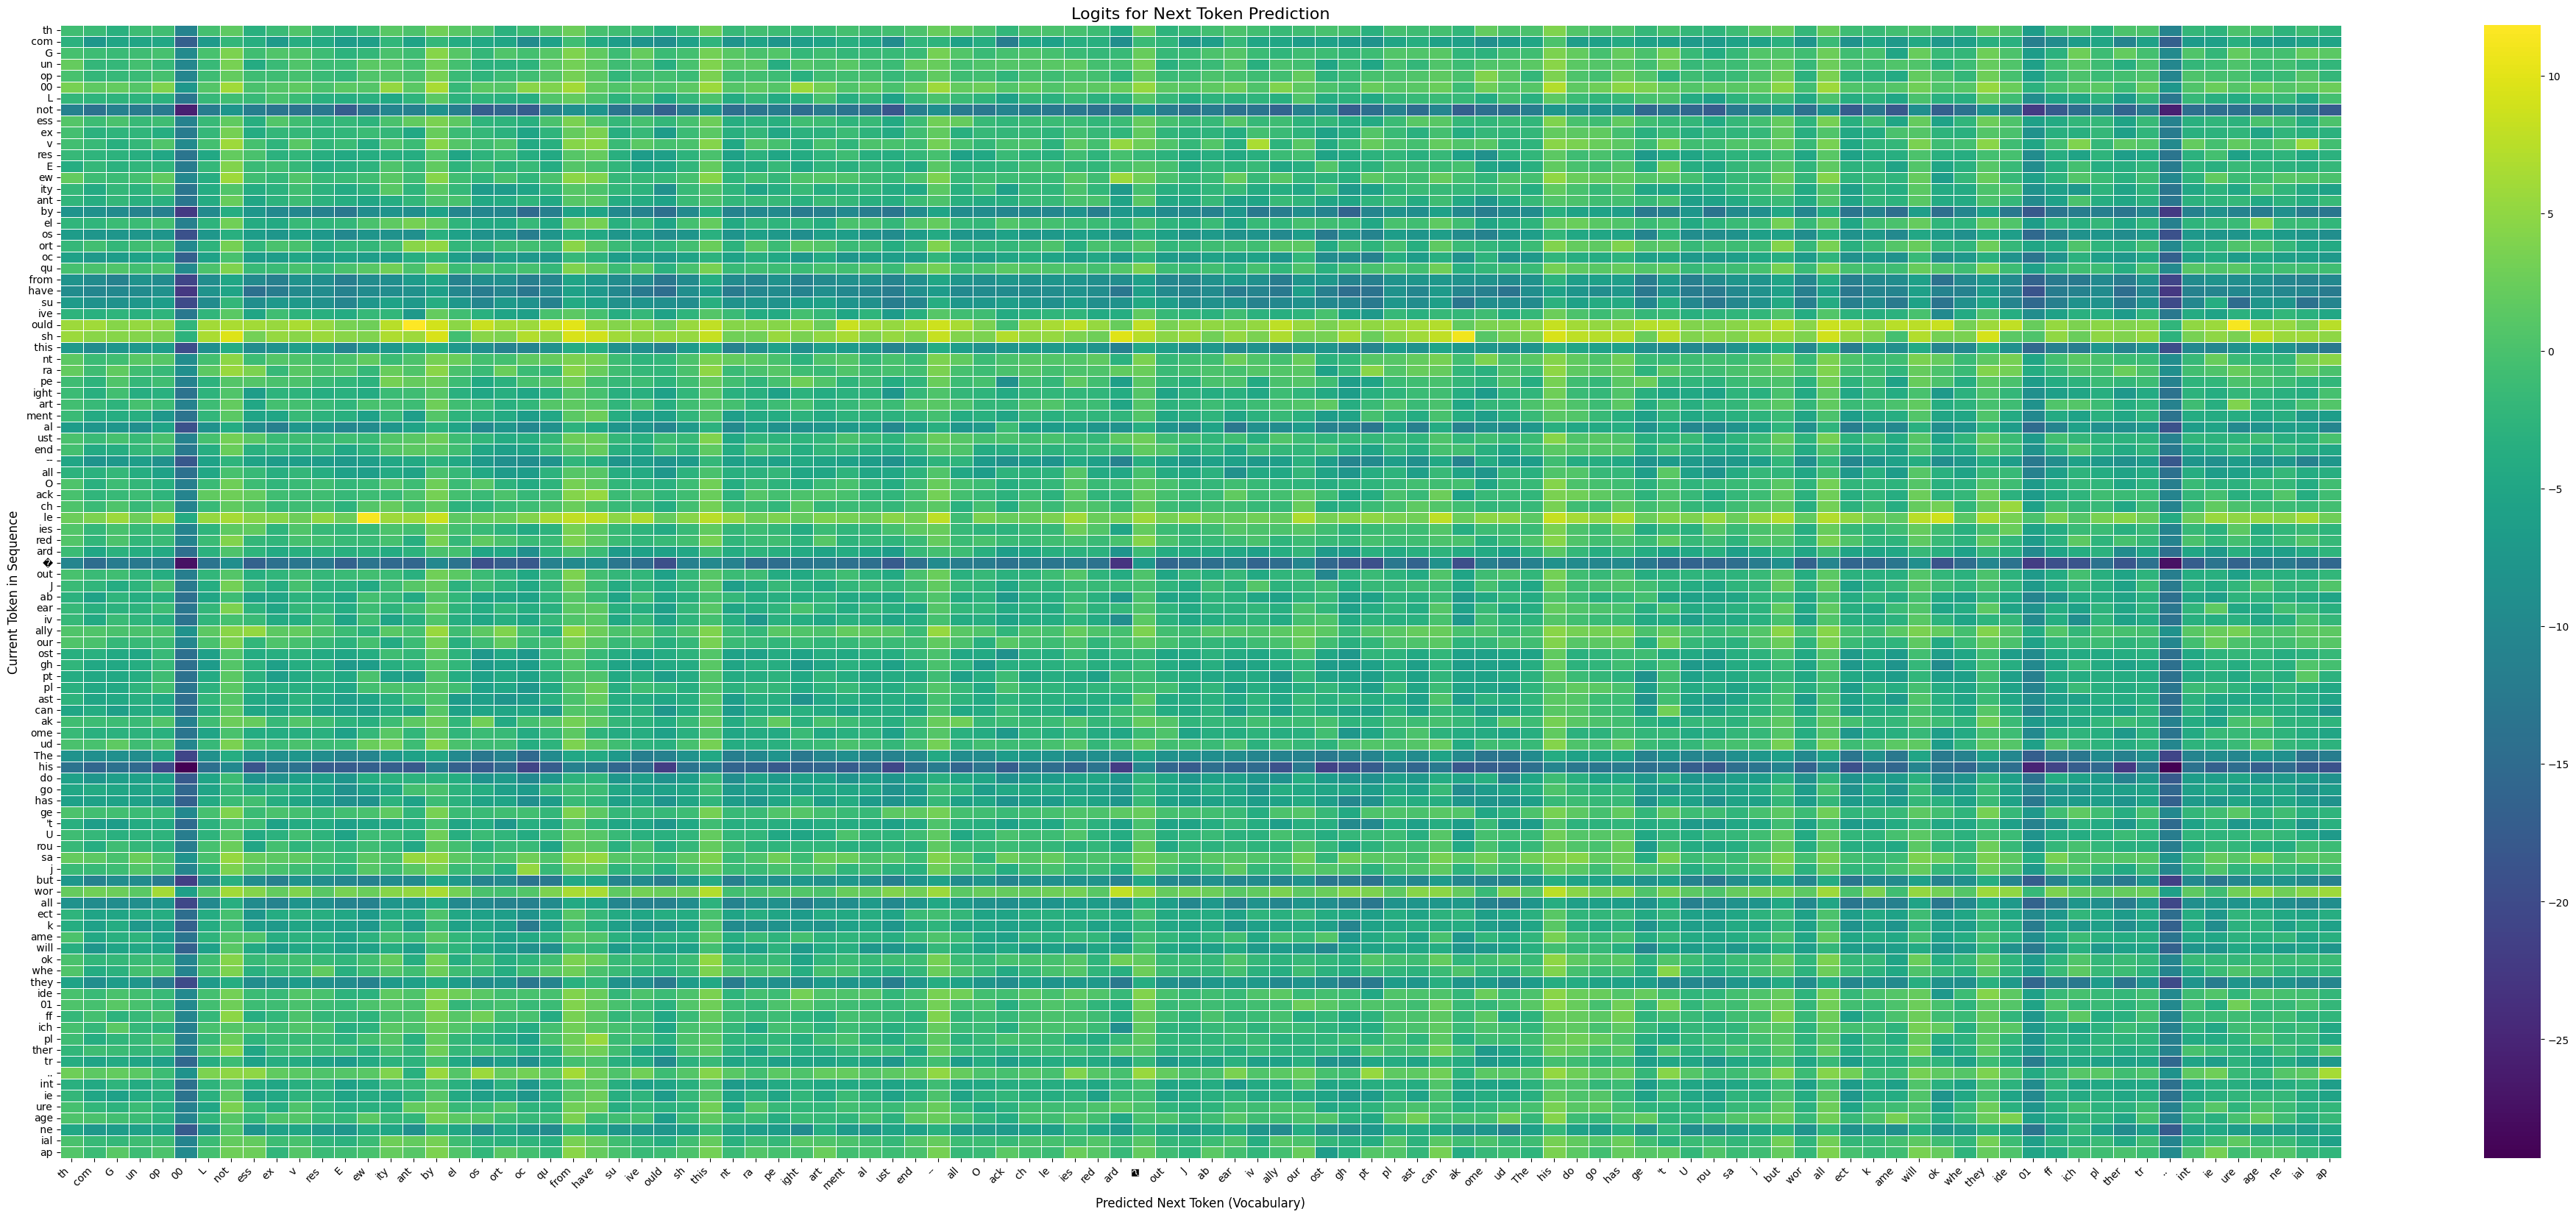

In [17]:
import seaborn as sns
logits_data = logits_.detach().numpy()
plt.figure(figsize=(50, 20))
from_range = 400
range_to_show = from_range + 100
y_labels = x_labels = [enc.decode([i]) for i in range(len(logits_data))]
ax = sns.heatmap(
    logits_data[from_range:range_to_show, from_range:range_to_show], 
    xticklabels=x_labels[from_range:range_to_show],
    yticklabels=y_labels[from_range:range_to_show],
    cmap='viridis',
    linewidths=.5,
)

ax.set_title("Logits for Next Token Prediction", fontsize=16)
ax.set_xlabel("Predicted Next Token (Vocabulary)", fontsize=12)
ax.set_ylabel("Current Token in Sequence", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

In [18]:
max_data = np.argmax(logits_data, axis=1)
for i, e in zip(max_data, range(vocab_size)):
    print(f"start: '{enc.decode([e])}', next: {enc.decode([i])}")

start: '!', next: 

start: '"', next: I
start: '#', next: ,
start: '$', next: ,
start: '%', next: ,
start: '&', next: ,
start: ''', next: er
start: '(', next: 2
start: ')', next: ,
start: '*', next: ,
start: '+', next: ,
start: ',', next: 

start: '-', next: 

start: '.', next: 

start: '/', next:  the
start: '0', next: ,
start: '1', next: 

start: '2', next: ,
start: '3', next:  KING
start: '4', next: ,
start: '5', next: ,
start: '6', next: ,
start: '7', next: ,
start: '8', next: ,
start: '9', next: ,
start: ':', next: 

start: ';', next: 

start: '<', next: ,
start: '=', next: ,
start: '>', next: ,
start: '?', next: 

start: '@', next: ,
start: 'A', next: ,
start: 'B', next: UCK
start: 'C', next: ES
start: 'D', next: U
start: 'E', next: 

start: 'F', next: ID
start: 'G', next: AR
start: 'H', next: EN
start: 'I', next: US
start: 'J', next: UL
start: 'K', next: ATH
start: 'L', next: AD
start: 'M', next: IR
start: 'N', next: urse
start: 'O', next: ,
start: 'P', next: OM
start: 'Q', next

In [19]:
def sample_from_model(model, start_text, encoder, max_new_tokens, temperature=1.0, top_k=50):
    model.eval()
    model.to(device)

    start_tokens = encoder.encode(start_text)
    idx = torch.tensor(start_tokens, dtype=torch.long, device=device)
    if idx.dim() == 1:
        idx = idx.unsqueeze(0) 

    for _ in range(max_new_tokens):
        logits = model(idx)
        logits = logits[:, -1, :] 
        
        logits = logits / temperature

        if top_k is not None:
            top_logits, top_idx = torch.topk(logits, top_k, dim=-1)
            logits_filtered = torch.full_like(logits, float('-inf'))
            logits_filtered.scatter_(1, top_idx, top_logits)
            logits = logits_filtered

        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)
        
        idx = torch.cat((idx, next_idx), dim=1)
        
    generated_tokens = idx.squeeze(0).cpu().numpy()
    return encoder.decode(generated_tokens)


In [20]:
start_prompt = "the meaning of life is"

generated_text = sample_from_model(
    model=model,
    start_text=start_prompt,
    encoder=enc,
    max_new_tokens=100,
    temperature=0.8,
    top_k=40
)

print("\n--- Generated Text ---")
print(generated_text)


--- Generated Text ---
the meaning of life is to me






B


killed.
And then of

POMPEYORK
prepared. They will be said the that he had and the
And his





And to his to his

And a great.
                                       
